# Глубинное обучение в анализе графовых данных, ПМИ ВШЭ

## Семинар 5

Сегодня погворим о графовых сверточных сетях для классификации вершин

Если вы знакомы со сверточными слоями, в GCN "свертка" - это почти та же операция - умножение входных нейронов на набор весов, которые обычно известны как фильтры или ядра. Фильтры действуют как скользящие окна по всему изображению и позволяют CNN изучать эмбеддинги из соседних клеток. В том же слое один и тот же фильтр будет использоваться по всему изображению. Например, используя CNN для классификации изображений кошек и не кошек, один и тот же фильтр будет использоваться в том же слое для обнаружения носа и ушей кошки.

GCN выполняют аналогичные операции, когда модель изучает особенности, проверя соседние узлы. Основное различие между CNN и GNN заключается в том, что CNN специально построены для работы с обычными (евклидовыми) структурированными данными, в то время как GNN являются обобщенной версией CNN, где количество ребер варьируется, а вершины неупорядочены.

[![1.jpg](https://i.postimg.cc/mkxWbctf/1.jpg)](https://postimg.cc/G8j5KmFq)
Иллюстрация 2D сверточных нейронных сетей и графических сверточных сетей [источник](https://arxiv.org/pdf/1901.00596.pdf)

Построние GCN можно разделить на 2 основных алгоритма: Spatial Graph Convolutional Networks и Spectral Graph Convolutional Networks. Здесь будем рассматривать спектарльный подход [Fast Approximation Spectral-based Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf).

### Fast Approximate Spectral Graph Convolutional Networks

Первоначальная идея Spectral GCN была вдохновлена распространением сигнала/волны. Мы можем думать о распространении информации в Spectral GCN как о распространении сигнала по вершинам. Спектральные GCN используют собственное разложение матрицы Лапласиана графа. Проще говоря, собственное разложение помогает нам понять структуру графа и, следовательно, классифицировать вершины графов. Это несколько похоже на базовую концепцию анализа гланых компонентов (PCA) и линейного дискриминантного анализа (LDA), где мы используем собственное разложение для уменьшения размерности и выполнения кластеризации.

В этом подходе мы будем учитывать матрицу смежности (A) в прямом распространении в дополнение к эмбеддингов вершин. Вставка A в уравнение прямого прохода позволяет модели изучать представления функций на основе связности вершин. Для простоты смещение опущено. Полученный GCN можно рассматривать как аппроксимацию первого порядка свертки спектрального графа в виде сети передачи сообщений, в которой информация распространяется по соседним вершинам внутри графа.
$$H^{i+1} = \sigma (W^i H^i A^*)$$
где $A^*$ - норализованная матрица (поговорим об этом ниже)

Graph Info:
 Graph named 'G' with 6 nodes and 7 edges

Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5})]


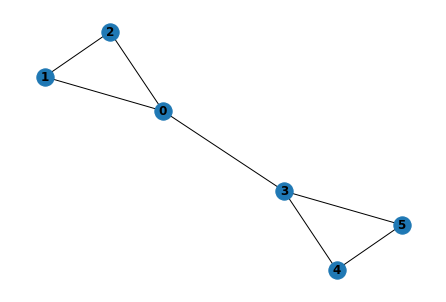

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings('ignore')

#Initialize the graph
G = nx.Graph(name='G')

#Create nodes
#In this example, the graph will consist of 6 nodes.
#Each node is assigned node feature which corresponds to the node name
for i in range(6):
    G.add_node(i, name=i)


#Define the edges and the edges to the graph
edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5)]
G.add_edges_from(edges)

#See graph info
print('Graph Info:\n', nx.info(G))

#Inspect the node features
print('\nGraph Nodes: ', G.nodes.data())

#Plot the graph
nx.draw(G, with_labels=True, font_weight='bold')

In [2]:
#Get the Adjacency Matrix (A) and Node Features Matrix (X) as numpy array
A = np.array(nx.attr_matrix(G, node_attr='name')[0])
X = np.array(nx.attr_matrix(G, node_attr='name')[1])
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (6, 6)

Shape of X:  (6, 1)

Adjacency Matrix (A):
 [[0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0.]]

Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [3]:
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[6.]
 [2.]
 [1.]
 [9.]
 [8.]
 [7.]]


Скалярное произведение матрицы смежности и матрицы эмбеддингов вершин представляет собой сумму эмбеддингов соседних вершин.

Но есть проблема. Хотя AX суммирует эмбеддинги смежных вершин, но не принимает во внимание особенности самой вершины

#### Вставка циклов и нормализация A

In [4]:
#Add Self Loops
G_self_loops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))

G_self_loops.add_edges_from(self_loops)

#Check the edges of G_self_loops after adding the self loops
print('Edges of G with self-loops:\n', G_self_loops.edges)

#Get the Adjacency Matrix (A) and Node Features Matrix (X) of added self-lopps graph
A_hat = np.array(nx.attr_matrix(G_self_loops, node_attr='name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

#Calculate the dot product of A_hat and X (AX)
AX = np.dot(A_hat, X)
print('AX:\n', AX)

Edges of G with self-loops:
 [(0, 1), (0, 2), (0, 3), (0, 0), (1, 2), (1, 1), (2, 2), (3, 4), (3, 5), (3, 3), (4, 5), (4, 4), (5, 5)]
Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1.]]
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [12.]
 [12.]
 [12.]]


Теперь есть еще одна проблема. Элементы AX не нормированы. Подобно предварительной обработке данных для любой операции нейронных сетей, нам необходимо нормализовать эмбеддинги, чтобы предотвратить численную нестабильность и исчезающие/взрывающиеся градиенты, чтобы модель сходилась. В GCN мы нормализуем наши данные, вычисляя матрицу степеней (D) и выполняя скалярное произведение обратной матрицы D с AX.

In [10]:
#Get the Degree Matrix of the added self-loops graph
Deg_Mat = G_self_loops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

#Convert the Degree Matrix to a N x N matrix where N is the number of nodes
D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)

#Find the inverse of Degree Matrix (D)
D_inv = np.linalg.inv(D)
print('Inverse of D:\n', D_inv)

#Dot product of D and AX for normalization
DAX = np.dot(D_inv,AX)
print('DAX:\n', DAX)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 5), (4, 4), (5, 4)]
Degree Matrix of added self-loops G as numpy array (D):
 [[5 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 4 0]
 [0 0 0 0 0 4]]
Inverse of D:
 [[0.2  0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.  ]
 [0.   0.   0.   0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25]]
DAX:
 [[1.2 ]
 [0.75]
 [0.75]
 [2.4 ]
 [3.  ]
 [3.  ]]


Можем увидеть влияние нормализации на DAX, где элемент, соответствующий 3-ей вершине, имеет значения меньше по сравнению с вершинами 4 и 5. Но почему 3-ья вершина имеет другие значения после нормализации, если она имеет то же начальное значение, что и узлы 4 и 5?

Еще раз посмотрим на наш граф. Вершина 3 имеет 3 ребра, а вершины 4 и 5 имеют только 2 по ребра. Тот факт, что вершина 3 имеет более высокую степень, чем вершины 4 и 5, приводит к более низкому весу эмбеддингов вершины 3 в DAX. Другими словами, чем ниже степень вершины, тем сильнее принадлежность вершины к определенной группе или кластеру.

В [статье](https://arxiv.org/pdf/1609.02907.pdf) утверждают, что выполнение симметричной нормализации сделает динамику более интересной, поэтому уравнение нормализации изменено:

$$normalized features = D^{1/2}AD^{1/2}$$

In [6]:
#Symmetrically-normalization
D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)
print('DADX:\n', DADX)

DADX:
 [[1.27082039]
 [0.75      ]
 [0.75      ]
 [2.61246118]
 [2.92082039]
 [2.92082039]]


### Создадим простую GCN сеть

In [7]:
#Initialize the weights
np.random.seed(1)
n_h = 4 #number of neurons in the hidden layer
n_y = 2 #number of neurons in the output layer
W0 = np.random.randn(X.shape[1],n_h) * 0.01
W1 = np.random.randn(n_h,n_y) * 0.01

#Implement ReLu as activation function
def relu(x):
    return np.maximum(0,x)

#Build GCN layer
#In this function, we implement numpy to simplify
def gcn(A,H,W):
    I = np.identity(A.shape[0]) #create Identity Matrix of A
    A_hat = A + I #add self-loop to A
    D = np.diag(np.sum(A_hat, axis=0)) #create Degree Matrix of A
    D_half_norm = fractional_matrix_power(D, -0.5) #calculate D to the power of -0.5
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)


#Do forward propagation
H1 = gcn(A,X,W0)
H2 = gcn(A,H1,W1)
print('Features Representation from GCN output:\n', H2)

Features Representation from GCN output:
 [[0.00025561 0.        ]
 [0.00015929 0.        ]
 [0.00015929 0.        ]
 [0.00048822 0.        ]
 [0.00049817 0.        ]
 [0.00049817 0.        ]]


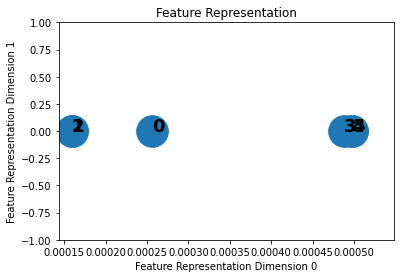

In [8]:
def plot_features(H2):
    #Plot the features representation
    x = H2[:,0]
    y = H2[:,1]

    size = 1000

    plt.scatter(x,y,size)
    plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(H2):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=18, fontweight='bold')

    plt.show()


plot_features(H2)

Из приведенного выше графа видно, что есть 2 основные группы, где левая группа состоит из узлов 0, 1, 2, а правая группа состоит из узлов 3, 4, 5. Можно сделать вывод, что GCN могут обучиться представлениям даже без обучения или обратного распространения ошибки.

__Выводы:__

Термин «свертка» в графовых сверточных сетях похож на сверточные нейронные сети с точки зрения распространения весов. Основное отличие заключается в структуре данных, где GCN — это обобщенная версия CNN, которая может работать с нерегулярными структурами.

Вставка матрицы смежности (A) в уравнение прямого прохода GCN позволяет модели изучить особенности соседних узлов. Этот механизм можно рассматривать как операцию передачи сообщений по узлам внутри графа.

Renormalization trick используется для нормализации фичей в сверточных сетях Fast Approximate Spectral Graph Convolutional Networks (2017).

Еще одна [статья](http://tkipf.github.io/graph-convolutional-networks/) для понимания сверточноых слоев в графовых сетях.

## Создание Message Passing сетей

Далее реализуем слой **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) напрямую. Затем мы запустим наши модели в наборе данных CORA, который является стандартным набором данных.

In [ ]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
# !pip install torch-geometric
# !pip install -q git+https://github.com/snap-stanford/deepsnap.git

Ниже приведена реализация общего модуля GNN, куда мы можем подключить любой слой GNN

In [28]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax


class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'Conv':
            return  torch_geometric.nn.GCNConv
        else:
            raise Exception('Not implemented!') 

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Теперь приступим к реализации наших собственных Message Passing слоев. Для этого мы будем работать и реализовывать 3 функции, необходимые для передачи и обработки сообщений: `forward`, `message`, и `aggregate`.

Пройдемся по ключевым компонентам процесса передачи сообщений. Для этого мы сосредоточимся на передаче сообщений относительно одной центральной вершины $x$. Перед передачей сообщения $x$ связывается с вектором признаков $x^{l-1}$, и целью передачи сообщения является обновление этого вектора признаков как $x^l$. Для этого реализуем следующие шаги: 1) каждый соседний узел $v$ передает свое текущее сообщение $v^{l-1}$ через ребро $(x, v)$ - 2) для узла $x$ , мы объединяем все сообщения соседних узлов (например, через сумму или среднее значение) - и 3) мы преобразуем агрегированную информацию, например, применяя линейные и нелинейные преобразования. В целом процесс передачи сообщений применяется таким образом, что каждый узел $u$ в нашем графе обновляет свое вложение, действуя как центральный узел $x$ на шагах 1-3, описанных выше.

Теперь, расширив этот процесс до одного уровня передачи сообщений, задача уровня передачи сообщений заключается в обновлении текущего представления функций или внедрении каждой вершины в граф путем распространения и преобразования информации в графе. В целом, общая парадигма уровней передачи сообщений: 1) предварительная обработка -> 2) **передача сообщения**/распространение -> 3) постобработка.

Функция `propagate` инкапсулирует процесс передачи сообщения. Она делает это, вызывая три функции: 1) `message`, 2)  `aggregate`, и 3) `update`. Наша реализация будет немного отличаться от этой, так как мы не будем явно реализовывать `update`, а вместо этого поместим логику для обновления эмбеддингов узлов после передачи сообщения и внутри функции `forward`. После передачи сообщения мы можем дополнительно преобразовать вложения узлов, полученные с помощью `propagate`. И так, выходы из `forward` — это эмбеддинги вершин после одного слоя GNN.


Обсудим подробнее:

1. 

```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
Вызов `propagate` инициирует процесс передачи сообщения. Глядя на параметры функции, мы выделим пару ключевых параметров.

   - `edge_index` передается forward функции и получает структуру ребер графа.
   - `x=(x_i, x_j)` представляет эмбеддинги вершин, которые будут использоваться при передаче сообщений. Чтобы объяснить, почему мы передаем `(x_i, x_j)`, мы сначала посмотрим, как представлены наши ребра. Для каждого ребра $(i, j) \in \mathcal{E}$ мы можем дифференцировать $i$ как исходный или центральный узел ($x_{central}$) и j как соседний узел ($x_{neighbor}$).
   
Взяв пример передачи сообщений выше, для центрального узла $u$ мы будем агрегировать и преобразовывать все сообщения, связанные с узлами $v$ и т.д.  $(u, v) \in \mathcal{E}$ (т. е. $v \in \mathcal{N}_{u}$). Таким образом, мы видим, что индексы `_i` и `_j` позволяют нам конкретно различать эмбеддинги, связанные с центральными узлами (т. е. узлами, получающими информацию о сообщениях) и соседними узлами (т. е. узлами, передающими сообщения).

Одна ключевая вещь, которую следует понимать, заключается в том, что в зависимости от точки зрения узел $x$ действует как центральный узел или соседний узел. Фактически, в неориентированных графах мы храним оба направления ребер (т. е. $(i, j)$ и $(j, i)$). С точки зрения центрального узла, `x_i`, x собирает соседнюю информацию для обновления своего внедрения. С точки зрения соседнего узла, `x_j`, x передает информацию о своем сообщении вдоль ребра, соединяющего его с другим центральным узлом.

  - `extra=(extra_i, extra_j)` представляет дополнительную информацию, которую мы можем связать с каждым узлом помимо его текущего внедрения функций. На самом деле, мы можем включить столько дополнительных параметров вида `param=(param_i, param_j)`, сколько захотим. Опять же, мы подчеркиваем, что индексирование с помощью `_i` и `_j` позволяет нам различать центральные и соседние узлы.

  Выход функции `propagate` представляет собой матрицу эмбеддингов вершин после процесса передачи сообщения и имеет форму $[N, d]$.

2. 
```
def message(x_j, ...):
```
Функция `message` вызывается функцией propagate и создает сообщения из соседних вершин $j$ с центральными узлами $i$ для каждого ребра $(i, j)$ в *edge_index*. Эта функция может принимать любой аргумент, который изначально был передан в функцию `propagate`. Кроме того, мы снова можем различать центральные узлы и соседние узлы, добавляя `_i` или `_j` к имени переменной, т.е. `x_i` и `x_j`. Глядя более конкретно на переменные, мы имеем:

   - `x_j` представляет собой матрицу эмбеддингов признаков для всех соседних узлов, передающих свои сообщения по соответствующему ребру (т. е. все узлы $j$ для рёбер $(i, j) \in \mathcal{E}$). Таким образом, его форма равна $[|\mathcal{E}|, d]$!

  Важно, что выход `message` функции представляет собой матрицу эмбеддингов соседних узлов, готовую к агрегированию, имеющую форму $[|\mathcal{E}|, d]$.

3. 
```
def aggregate(self, inputs, index, dim_size = None):
```
Наконец, функция `aggregate` используется для агрегирования сообщений от соседних вершин:

   - `inputs` представляют собой матрицу сообщений, переданных от соседних узлов (т.е. вывод функции `message`).
   - `index` имеет ту же форму, что и `inputs`, и сообщает нам центральный узел, соответствующий каждой из строк/сообщений $j$ в матрице `inputs`. Таким образом, `index` говорит нам, какие строки/сообщения агрегировать для каждого центрального узла.

   Выход `aggregate` имеет форму $[N, d]$.
   
Дополнительные ресурсы см. в документации PyG для реализации своих Message Passing слоев: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html.

Теперь реализуем свой слой GraphSage ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216))

Для данного *центрального* узла $v$ с текущим эмбеддингом $h_v^{l-1}$ правило обновления передачи сообщений для преобразования $h_v^{l-1} \rightarrow h_v^l$ выглядит следующим образом:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

где $W_1$ и $W_2$ — обучамые матрицы весов, а узлы $u$ — *соседние* узлы. Кроме того, для простоты мы используем среднее агрегирование:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Следует отметить, что мы добавляем **skip connections** в нашу реализацию GraphSage через $W_l\cdot h_v^{(l-1)}$.

Наконец, после каждой итерации применяется L-2 нормализация эмбеддингов вершин.

In [19]:
class GraphSage(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize=True,
                 bias=False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size=None):
        # x is shape (N, in_c)
        neighbor_out = self.propagate(edge_index, x=(x, x), size=size)
        out = self.lin_l(x) + self.lin_r(neighbor_out)
        if self.normalize:
            out = torch.nn.functional.normalize(out, p=2)

        return out

    def message(self, x_j):
        # x_j has shape (E, d)
        out = x_j
        return out

    def aggregate(self, inputs, index, dim_size=None):
        node_dim = self.node_dim

        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')

        return out


In [20]:
import torch.optim as optim


def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler is None:
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

### Обучение GNN

In [21]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    print()
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            test_accs.append(test_acc)
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = copy.deepcopy(model)
        else:
            test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
            print ("Saving Model Predictions for Model Type", model_type)

            data = {}
            data['pred'] = pred.view(-1).cpu().detach().numpy()
            data['label'] = label.view(-1).cpu().detach().numpy()

            df = pd.DataFrame(data=data)
            # Save locally as csv
            df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class ObjectView(object):
    def __init__(self, d):
        self.__dict__ = d


In [22]:
args = {
    'model_type': 'GraphSage',
    'dataset': 'cora',
    'num_layers': 2,
    'heads': 1,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.5,
    'epochs': 500,
    'opt': 'adam',
    'opt_scheduler': None,
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'lr': 0.01
}

In [23]:
args = ObjectView(args)

Maximum test set accuracy: 0.79
Minimum loss: 0.10159359127283096
Saving Model Predictions for Model Type GraphSage



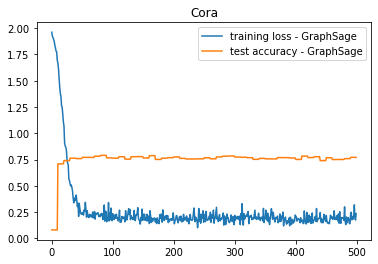

In [27]:
model = 'GraphSage'
if args.dataset == 'cora':
    dataset = Planetoid(root='/tmp/cora', name='Cora')
else:
    raise NotImplementedError("Unknown dataset") 
test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# Run test for our best model to save the predictions!
test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
print()

plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()

Node task. test set size: 1000



Training: 100%|███████████████████████████| 500/500 [00:24<00:00, 20.40Epochs/s]


Maximum test set accuracy: 0.785
Minimum loss: 0.05334124714136124
Saving Model Predictions for Model Type Conv



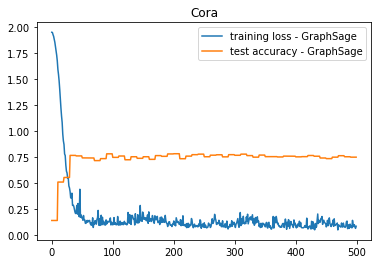

In [31]:
args = {
    'model_type': 'GraphSage',
    'dataset': 'cora',
    'num_layers': 4,
    'heads': 1,
    'batch_size': 32,
    'hidden_dim': 32,
    'dropout': 0.3,
    'epochs': 500,
    'opt': 'adam',
    'opt_scheduler': None,
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'lr': 0.01
}
args = ObjectView(args)
model = 'Conv'
if args.dataset == 'cora':
    dataset = Planetoid(root='/tmp/cora', name='Cora')
else:
    raise NotImplementedError("Unknown dataset") 
test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# Run test for our best model to save the predictions!
test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
print()

plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - " + args.model_type)
plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
plt.legend()
plt.show()